# **Tutorial 2: Multi-Armed Bandits**

## **Section 1: Introduction**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for plotting
import pandas as pd
from IPython.display import display, HTML

![maby.png](https://miro.medium.com/max/3000/1*vaG1QOAdAgVsRWfFYjug_Q.png)



A simple description of the k-armed MAB setting is:
You are faced repeatedly with a choice among
k different options, or actions. After each choice you receive a numerical reward chosen
from a stationary probability distribution that depends on the action you selected.

Your objective will be to use $\epsilon$-greedy and softmax algorihms to asymptotically estimate the arm with best expected reward, by balancing exploration and exploitation.

### **Estimating and Visualizing Probability Distributions**

Below we set up some parameters which we will later use for sampling rewards when pulling an arm.

In [2]:
seed = 42 # for reproducibility
np.random.seed(seed)

# get some distribution parameters 
loc = np.random.random((2,))
scale = np.random.random((2,)) * 5 # (guassian dist.)

low = -np.random.random((2,)) * 2
high = np.random.random((2,)) * 2 # (uniform dist.)

lam = np.random.random((2, )) * 3 # (poisson dist.)

a = np.random.random((2,)) * 2
b = np.random.random((2,)) * 2 # (beta dist.)

# calculating true means for comparision
true_means = [*loc, *(high+low)/2, *lam, *(a/(a+b))]

Note 1: The above numbers are chosen arbitrarily. They have no particular significance.  
Note 2: For real world problems, true means will not be available to you. Here since we know the parameters as well as the distribution, we can analytically calculate the true means. This is only for the sake of the exercise.

Below we define our multi-armed bandit.

In [3]:
def pull_MAB(arm=None):
    '''
    pulls the requested arm and returns a reward
    ''' 
    if arm in [0, 1]:
        return np.random.normal(loc[arm], scale[arm])
    elif arm in [2, 3]:
        arm -= 2
        return np.random.uniform(low[arm], high[arm])
    elif arm in [4, 5]:
        arm -= 4
        return np.random.poisson(lam[arm])
    elif arm in [6, 7]:
        arm -= 6
        return np.random.beta(a[arm], b[arm])

Let us pull each arm 1000 times to get enough samples for estimation and plotting.

In [4]:
# collecting samples
rewards = np.zeros((8, 1000))
for arm in range(8):
    for i in range(1000):
        rewards[arm, i] = pull_MAB(arm)

Now that we have collected samples for each arm, we can analyse them.

In [5]:
# Calc est. mean and compare with true mean
est_means = [np.mean(rewards[arm]) for arm in range(8)]
df = pd.DataFrame({"Arm": list(range(8)), "True Mean": true_means, "Est. Means": est_means})
display(HTML((df.to_html(index=False))))

Arm,True Mean,Est. Means
0,0.374540,0.446731
1,0.950714,1.139722
2,-0.097935,-0.099509
3,0.710182,0.684619
4,1.803345,1.784000
5,2.124218,2.131000
6,0.024131,0.023603
7,0.820394,0.811318


Pretty close! The estimate will become closer to the true mean with even more samples. Feel free to test it out.

Now let us see how the spread of the rewards (distribution) looks like. If you find the plotting code daunting, it is okay to skip it. The aim is to see examples of some reward distributions and how the sampled rewards from the arms approximate the distributions.

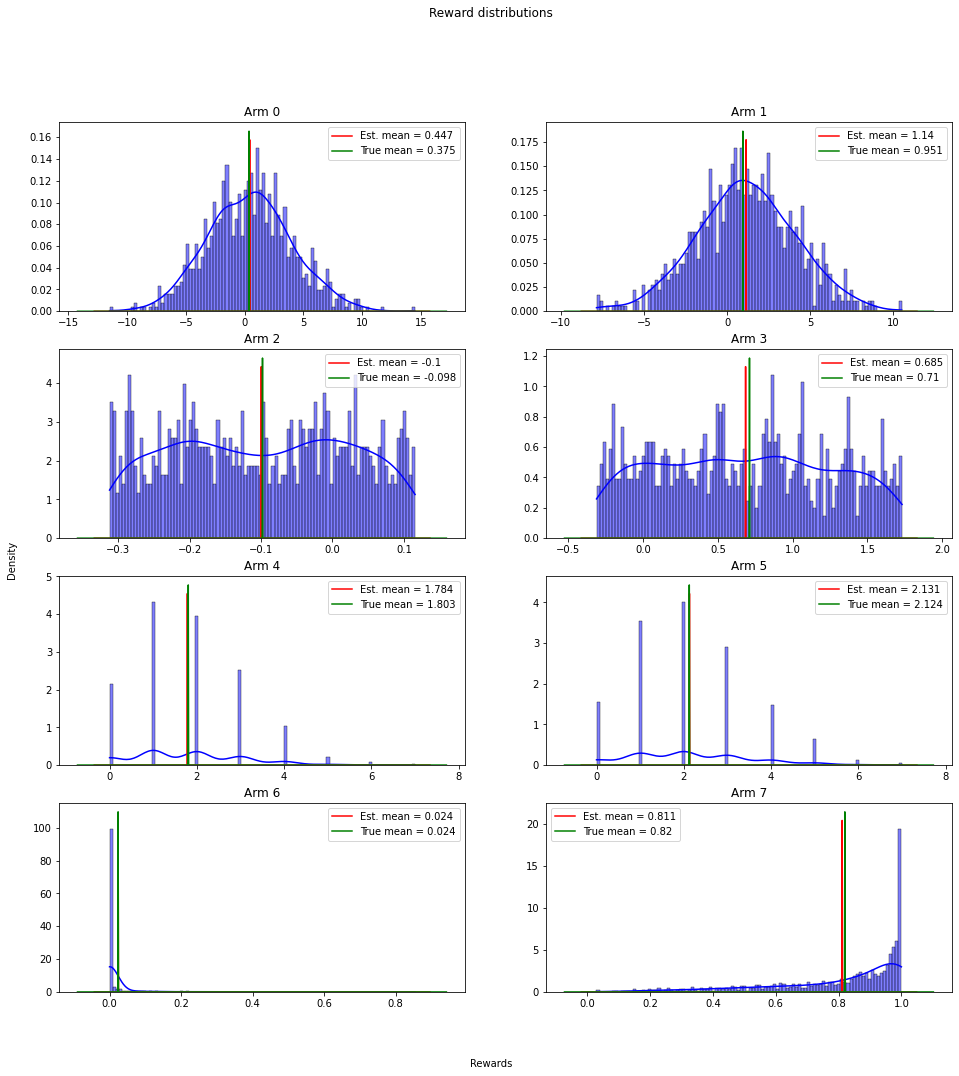

In [6]:
# plot each distribution

%matplotlib inline

def get_unit_impulse(low, high, val, scale, size=1000):
    x = np.arange(low, high, (high-low)/size)
    y = np.zeros(x.shape)
    y[ np.abs(x-val).argmin() ] = scale
    return x, y

fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(16,16))
fig.suptitle('Reward distributions')

for arm in range(8):
    ax = axes[arm//2, arm%2]
    sns.histplot(rewards[arm], ax=ax, stat="density", kde=True, bins=100, color="blue")
    ax.plot(*get_unit_impulse(*ax.get_xlim(), np.mean(rewards[arm]), ax.get_ylim()[1]),
            label="Est. mean = {}".format(round(np.mean(rewards[arm]), 3)), color="red")
    ax.plot(*get_unit_impulse(*ax.get_xlim(), true_means[arm], ax.get_ylim()[1]),
            label="True mean = {}".format(round(true_means[arm], 3)), color="green")
    ax.set_ylabel("")
    ax.set_title(f"Arm {arm}")
    ax.legend()

fig.text(0.5, 0.06, 'Rewards', ha='center')
fig.text(0.08, 0.5, 'Density', va='center', rotation='vertical')
plt.show()

Above plots show examples of 4 common types of tractable distributions (Gaussian, Uniform, Poisson, Beta) with 2 arms for each. It can be incredibly useful to know the underlying distribution of your samples but in real world problems, more often than not, it is extremely difficult to find out.
  
But that doesn't stop us from estimating their properties such as mean or variance. Because estimating is what you do when you don't know. And you know nothing, Jon Snow!

## **Section 2: Implementing $\epsilon$-greedy and softmax on Gaussian bandits**

***(sample outputs shown everywhere using a different random seed)***

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from collections import namedtuple

In [9]:
num_arms = 5

**Task 1: Function to implement the $\epsilon$-greedy algorithm**

The expected outputs to be returned from the `eps_greedy` function are given. These outputs will be used to plot some graphs that provide insights. Your task is to fill in the core steps of the epsilon-greedy action selection and q-estimate updation.

In [10]:
def pull_MAB(arm=None, mus = None):
    rew = np.random.normal(loc=mus[arm], scale=1)
    return rew

In [27]:
def eps_greedy(epsilon, num_arms, mus):
    
    q = np.zeros((num_arms))                # Q-estimates (empirical expected rewards) initialised at 0
    times_sampled = np.zeros((num_arms))    # Keeps track of number of times each arm has been sampled

    # List of 5 lists to store the sequence of Q-estimates for each arm, over time
    # Will be useful to plot convergence of Q-estimates
    q_of_all_arms_over_time = [[] for _ in range(num_arms)]

    # List to store all rewards obtained over time
    rewards = []

    '''YOUR CODE HERE'''
    for t in range(2000):
      arm = -1
      k = np.random.uniform(0, 1)
      # Epsilon-greedily picking an action
      if k >= epsilon:
        arm = np.argmax(q)
      else:
        arm = np.random.randint(num_arms)

      # Increment the sample count of the selected arm
      times_sampled[arm] += 1

      # Pulling the arm to get a sample reward (using pull_MAB function)
      # and storing the reward in the list for later plotting
      r = pull_MAB(arm, mus)
      rewards.append(r)
  
      # Stochastic averaging (online update) of Q-estimate
      qk = q[arm] + (r - q[arm])/times_sampled[arm]
      q[arm] = qk

      # Storing each Q-estimate at the current time step in the corresponding
      # list within "q_of_all_arms_over_time"
      for idx in range(num_arms):
        if idx == arm:
          q_of_all_arms_over_time[arm].append(qk)
        else:
          q_of_all_arms_over_time[idx].append(q[idx])

      # Comment out the pass when code is written
      #pass
        

    return q, rewards, q_of_all_arms_over_time

In [28]:
seed = 42   # Use random seed = 42
np.random.seed(seed)

# Generating a set of means for the Gaussian bandit arms, using the standard normal distribution
mus = np.random.randn(num_arms)

# Running the epsilon-greedy algorithm for three different values of epsilon

q1, rewards1, all_q1s = eps_greedy(epsilon=0, num_arms = num_arms, mus = mus)
q2, rewards2, all_q2s = eps_greedy(epsilon=0.01, num_arms = num_arms, mus = mus)
q3, rewards3, all_q3s = eps_greedy(epsilon=0.1, num_arms = num_arms, mus = mus)

**Plotting the convergence of Q-estimates over time**

In [29]:
# Helper function for plotting the Q-estimate convergence graphs

def q_plotter(title, qs, mus=None):

    '''
    title: The title for the plot - indicate the value of epsilon used
    qs: List of lists (one list for each arm) of Q-estimates over time
    mus: True values of expected/mean rewards (mu_star)
    '''

    colors = ['r','g','b','y','m']
    plt.figure(figsize=(10,6))

    for arm in range(len(qs)):
        plt.plot(qs[arm], color=colors[arm%5], label = f'Arm {arm}')
        if mus is not None:
            plt.axhline(y = mus[arm], color = colors[arm%5], linestyle = '--')

    plt.legend()
    plt.suptitle(title, fontweight = 'bold', fontsize = 14)
    plt.xlabel("Steps", fontweight = 'bold')
    plt.ylabel("Q-estimate", fontweight = 'bold')
    plt.grid(True)
    plt.show()

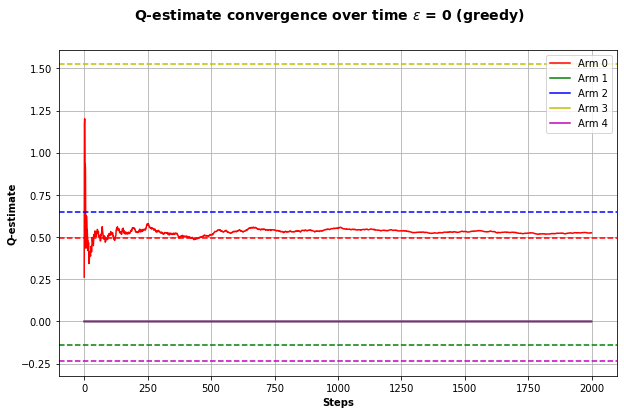

In [30]:
q_plotter('Q-estimate convergence over time $\epsilon$ = 0 (greedy)', all_q1s, 
          mus = mus)

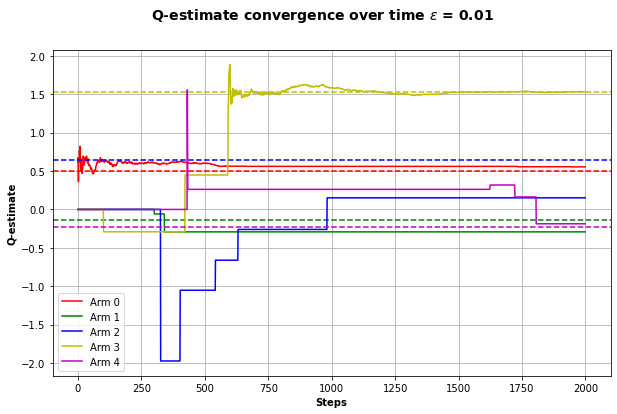

In [31]:
# Plot similar convergence plot for epsilon = 0.01

'''YOUR CODE HERE'''
q_plotter('Q-estimate convergence over time $\epsilon$ = 0.01', all_q2s, 
          mus = mus)

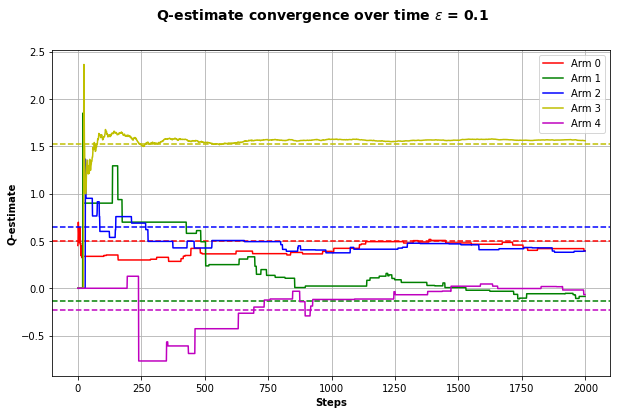

In [32]:
# Plot similar convergence plot for epsilon = 0.1

'''YOUR CODE HERE'''
q_plotter('Q-estimate convergence over time $\epsilon$ = 0.1', all_q3s, 
          mus = mus)

**Task 2: Evaluating the average behaviour of the $\epsilon$-greedy algorithm (averaged over independent runs)**

When we evaluate the average behaviour of the algorithm, we use the average across several runs of the experiment. Similar to earlier, the true means of the Gaussian bandit arms are drawn from a standard normal distribution.

However, the generated true means are different (random) for each independent run.

In [33]:
# Helper function for plotting the average reward graphs

def runs_plotter(title, xlbl, ylbl, plots, mu_star):
    
    '''
    title: The title for the plot - indicate the value of epsilon used
    xlbl: The x-axis label
    ylbl: The y-axis label
    plots: List of lists (one list for each arm) of Q-estimates over time
    mus: True values of expected/mean rewards (mus)
    '''

    plt.figure(figsize=(10,6))
    for values, lbl in plots:
        plt.plot(values, label = lbl)
    
    plt.legend()

    plt.axhline(mu_star, linestyle = '--', color = 'k', 
                label = 'Optimal mean reward')

    plt.suptitle(title, fontweight = 'bold', fontsize = 14)
    plt.xlabel(xlbl, fontweight = 'bold')
    plt.ylabel(ylbl, fontweight = 'bold')
    plt.grid(True)
    plt.show()

In [34]:
# Number of runs
num_runs = 1000

# Reinitialising the random seed for this experiment (only for reproducibility)
np.random.seed(seed)

# Should store the list of average rewards for each time step 
# Take the average across each of the runs

# For epsilon = 0
avg_r1 = []
# For epsilon = 0.01
avg_r2 = []
# For epsilon = 0.1
avg_r3 = []

# Variable to store average "highest mean reward (mu*)" across runs
avg_mu_star = 0

'''YOUR CODE HERE'''
for run in range(num_runs):
  # Generate a new bandit problem for each run
  mus_run = np.random.randn(num_arms)

  # Accumulate total mu* by addition (highest mean reward of arm)
  # Used to calculate average mu* at the end
  avg_mu_star += np.max(mus_run)
  
  # Execute epsilon-greedy for the three epsilon values, similar to earlier
  _, rewards1, _ = eps_greedy(epsilon=0, num_arms = num_arms, mus = mus_run)
  _, rewards2, _ = eps_greedy(epsilon=0.01, num_arms = num_arms, mus = mus_run)
  _, rewards3, _ = eps_greedy(epsilon=0.1, num_arms = num_arms, mus = mus_run)

  # Store the list of rewards for current run
  avg_r1.append(rewards1)
  avg_r2.append(rewards2)
  avg_r3.append(rewards3)

  # Comment out the pass after code has been written
  #pass

# Divide avg_mu_star by num_runs to obtain true average mu_star
avg_mu_star = avg_mu_star/num_runs

# Store 'average reward over time' plots in the avg_r1, avg_r2, avg_r3 variables
# using the reward lists of all runs previously stored
avg_r1 = np.mean(np.array(avg_r1), axis = 0)
avg_r2 = np.mean(np.array(avg_r2), axis = 0)
avg_r3 = np.mean(np.array(avg_r3), axis = 0)


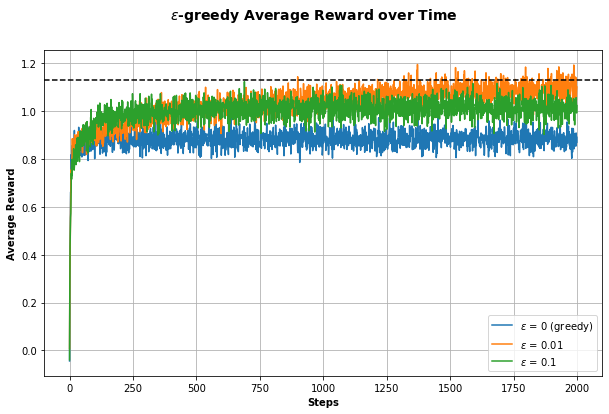

In [35]:
# Helper code to plot the average rewards

reqd_plots = [(avg_r1, '$\epsilon$ = 0 (greedy)'), 
            (avg_r2, '$\epsilon$ = 0.01'), 
            (avg_r3, '$\epsilon$ = 0.1')]

runs_plotter(title = '$\epsilon$-greedy Average Reward over Time',
        xlbl = 'Steps', ylbl = 'Average Reward', plots = reqd_plots, 
        mu_star = avg_mu_star)

________________________________________________

**Task 3: Function to implement the softmax algorithm**

Once again, your task is to fill in the core steps of the softmax action selection and q-estimate updation.

In [37]:
# Function to implement softmax

def softmax(temp, num_arms, mus):

    q = np.zeros((num_arms))                # Q-estimates (empirical expected rewards) initialised at 0
    times_sampled = np.zeros((num_arms))    # Keeps track of number of times each arm has been sampled

    '''
    # No need to store the sequences of Q-estimates for each arm, over time
    # As we won't need to demonstrate the convergence of Q-values

    OPTIONAL EXERCISE: Observe the differences in convergence of 
    Q-estimates over time for different values of temperature
    
    # q_of_all_arms_over_time = [[] for _ in range(num_arms)]
    '''

    # List to store all rewards obtained over time
    rewards = []

    '''YOUR CODE HERE'''
    for t in range(1000):

      arm = -1

      # Selecting an action according to the softmax strategy
      prob = np.exp(q/temp)
      prob = prob/np.sum(prob)
      arm = np.random.choice(num_arms, p = prob)
      
      # Incrementing the sampled count of the selected arm
      times_sampled[arm] += 1 

      # Pulling the arm to get a sample reward, (using pull_MAB function) 
      # and storing the reward in the list for plotting
      r = pull_MAB(arm, mus)
      rewards.append(r)

      # Stochastic averaging (online update) of Q-estimate
      qk = q[arm] + (r - q[arm])/times_sampled[arm]
      q[arm] = qk

      # Comment out the pass after entering the code
      #pass

    return q, rewards

**Task 4: Evaluating the average behaviour of the softmax algorithm (averaged over independent runs)**

In [38]:
# Number of runs
num_runs = 1000

# Reinitialising the random seed for this experiment (only for reproducibility)
np.random.seed(seed)

# Should store the list of average rewards for each time step 
# Take the average across each of the runs

# For beta = 0.01
avg_r1 = []
# For beta = 0.1
avg_r2 = []
# For beta = 1
avg_r3 = []
# For beta = 5
avg_r4 = []

# Variable to store average "highest mean reward (mu*)" across runs
avg_mu_star = 0

'''YOUR CODE HERE'''
for run in range(num_runs):

  # Generate a new bandit problem for each run
  mus_run = np.random.randn(num_arms)

  # Accumulate total mu* by addition (highest mean reward of arm)
  # Used to calculate average mu* at the end
  avg_mu_star += np.max(mus_run)

  # Execute softmax for the four temperature values, similar to earlier
  _, rewards1 = softmax(temp = 0.01, num_arms = num_arms, mus = mus_run)
  _, rewards2 = softmax(temp = 0.1, num_arms = num_arms, mus = mus_run)
  _, rewards3 = softmax(temp = 1, num_arms = num_arms, mus = mus_run)
  _, rewards4 = softmax(temp = 5, num_arms = num_arms, mus = mus_run)

  # Store the list of rewards of the current run
  avg_r1.append(rewards1)
  avg_r2.append(rewards2)
  avg_r3.append(rewards3)
  avg_r4.append(rewards4) 

  # Comment out the pass after code has been written
  #pass

# Divide avg_mu_star by num_runs to obtain true average mu_star
avg_mu_star = avg_mu_star/num_runs

# Store 'average reward over time' plots in avg_r1, avg_r2, avg_r3, avg_r4
# using the reward lists of all runs previously stored
avg_r1 = np.mean(np.array(avg_r1), axis = 0)
avg_r2 = np.mean(np.array(avg_r2), axis = 0)
avg_r3 = np.mean(np.array(avg_r3), axis = 0)
avg_r4 = np.mean(np.array(avg_r4), axis = 0)

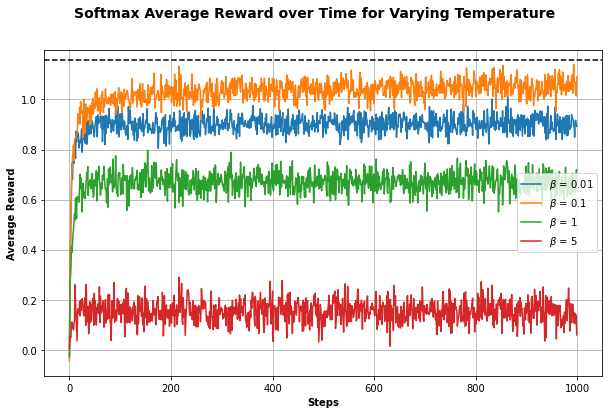

In [40]:
# Helper code to plot the average rewards
reqd_plots = [(avg_r1, '$\\beta$ = 0.01'), 
            (avg_r2, '$\\beta$ = 0.1'),
            (avg_r3, '$\\beta$ = 1'),
            (avg_r4, '$\\beta$ = 5')]

runs_plotter(title = 'Softmax Average Reward over Time for Varying Temperature',
        xlbl = 'Steps', ylbl = 'Average Reward', plots = reqd_plots, 
        mu_star = avg_mu_star)

____________________________________________________________________________